In [1]:
import math
import random
from os import path

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from torch.utils.data import DataLoader, TensorDataset

In [2]:
SEED = 491
N_SYN = 10000
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = "../../data/previous"
seer_path = path.join(data_path, "processed_seer_with_age.csv")
cohort_path = path.join(data_path, "processed_cohort_with_age.csv")

seer = pl.read_csv(seer_path)
cohort = pl.read_csv(cohort_path)

label_col = "target"
# Identifying discrete vs continuous for visualization and rounding
discrete_cols = ["age", "clinical_stage", "ISUP_grade", "biopsy_cores_positive", "biopsy_cores_examined"]
feature_cols = seer.select(pl.exclude(label_col)).columns
discrete_indices = [feature_cols.index(c) for c in discrete_cols]


In [3]:
def get_data_arrays(df):
    X = df.select(pl.exclude(label_col)).to_numpy().astype(np.float32)
    y = df.get_column(label_col).to_numpy().astype(np.int64)
    return X, y

X_seer, y_seer = get_data_arrays(seer)
X_cohort, y_cohort = get_data_arrays(cohort)

# Global scalers for uniformity
scaler_seer = StandardScaler().fit(X_seer)
scaler_cohort = StandardScaler().fit(X_cohort)

X_seer_std = scaler_seer.transform(X_seer)
X_cohort_std = scaler_cohort.transform(X_cohort)


In [4]:

def evaluate_preds(y_true, y_prob, name="Model"):
    # Dynamic thresholding: Find the threshold that gives the best F1 score
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]

    y_pred = (y_prob >= best_thresh).astype(int)

    return {
        "Model": name,
        "AUC": roc_auc_score(y_true, y_prob),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

def train_eval_svm(X_train, y_train, X_test, y_test, name):
    clf = SVC(probability=True, class_weight="balanced", random_state=SEED)
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)[:, 1]
    return evaluate_preds(y_test, probs, name)

def train_eval_nn(X_train, y_train, X_test, y_test, name):
    input_dim = X_train.shape[1]
    model = nn.Sequential(
        nn.Linear(input_dim, 64), nn.ReLU(),
        nn.Linear(64, 64), nn.ReLU(),
        nn.Linear(64, 2)
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    dl = DataLoader(ds, batch_size=64, shuffle=True)

    model.train()
    for _ in range(10):
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    model.eval()
    xt_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(xt_t)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

    return evaluate_preds(y_test, probs, name)


In [5]:
results_baseline = []
print("=== Baseline Cross-Training ===")

# Train SEER -> Test Cohort
print("Training on SEER -> Testing on Cohort...")
results_baseline.append(train_eval_svm(X_seer_std, y_seer, X_cohort_std, y_cohort, "SVM (Train: SEER)"))
results_baseline.append(train_eval_nn(X_seer_std, y_seer, X_cohort_std, y_cohort, "NN (Train: SEER)"))

# Train Cohort -> Test SEER
print("Training on Cohort -> Testing on SEER...")
results_baseline.append(train_eval_svm(X_cohort_std, y_cohort, X_seer_std, y_seer, "SVM (Train: Cohort)"))
results_baseline.append(train_eval_nn(X_cohort_std, y_cohort, X_seer_std, y_seer, "NN (Train: Cohort)"))

pl.DataFrame(results_baseline).write_csv(path.join(data_path, "baseline_results.csv"))
print(pl.DataFrame(results_baseline))


=== Baseline Cross-Training ===
Training on SEER -> Testing on Cohort...
Training on Cohort -> Testing on SEER...
shape: (4, 6)
┌─────────────────────┬──────────┬──────────┬───────────┬──────────┬──────────┐
│ Model               ┆ AUC      ┆ Accuracy ┆ Precision ┆ Recall   ┆ F1       │
│ ---                 ┆ ---      ┆ ---      ┆ ---       ┆ ---      ┆ ---      │
│ str                 ┆ f64      ┆ f64      ┆ f64       ┆ f64      ┆ f64      │
╞═════════════════════╪══════════╪══════════╪═══════════╪══════════╪══════════╡
│ SVM (Train: SEER)   ┆ 0.776507 ┆ 0.719388 ┆ 0.352113  ┆ 0.735294 ┆ 0.47619  │
│ NN (Train: SEER)    ┆ 0.791394 ┆ 0.673469 ┆ 0.329545  ┆ 0.852941 ┆ 0.47541  │
│ SVM (Train: Cohort) ┆ 0.739231 ┆ 0.677414 ┆ 0.14192   ┆ 0.690647 ┆ 0.235456 │
│ NN (Train: Cohort)  ┆ 0.704697 ┆ 0.782388 ┆ 0.156683  ┆ 0.46223  ┆ 0.234035 │
└─────────────────────┴──────────┴──────────┴───────────┴──────────┴──────────┘


In [54]:
# %%
# === Generative Models Definitions (Stabilized) ===

class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(input_dim + 1, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU())
        self.mu = nn.Linear(32, latent_dim)
        self.logvar = nn.Linear(32, latent_dim)
        self.dec = nn.Sequential(nn.Linear(latent_dim + 1, 32), nn.ReLU(), nn.Linear(32, 64), nn.ReLU(), nn.Linear(64, input_dim))

    def encode(self, x, c):
        h = self.enc(torch.cat([x, c], 1))
        return self.mu(h), self.logvar(h)

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

    def decode(self, z, c):
        return self.dec(torch.cat([z, c], 1))

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparam(mu, logvar)
        return self.decode(z, c), mu, logvar

class GAN_Gen(nn.Module):
    def __init__(self, z_dim, feat_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + 1, 128), nn.LeakyReLU(0.2), nn.BatchNorm1d(128),
            nn.Linear(128, 256), nn.LeakyReLU(0.2), nn.BatchNorm1d(256),
            nn.Linear(256, feat_dim)
        )
    def forward(self, z, c):
        return self.net(torch.cat([z, c], 1))

class GAN_Disc(nn.Module):
    def __init__(self, feat_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim + 1, 128), nn.LeakyReLU(0.2),
            nn.Linear(128, 64), nn.LeakyReLU(0.2),
            nn.Linear(64, 1), nn.Sigmoid()
        )
    def forward(self, x, c):
        return self.net(torch.cat([x, c], 1))

class DiffusionMLP(nn.Module):
    def __init__(self, in_dim, time_dim=32):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_dim), nn.SiLU(), nn.Linear(time_dim, time_dim)
        )
        self.label_emb = nn.Linear(1, time_dim)
        # Added LayerNorm to prevent value explosion (1e28)
        self.net = nn.Sequential(
            nn.Linear(in_dim + time_dim, 128), nn.LayerNorm(128), nn.SiLU(),
            nn.Linear(128, 128), nn.LayerNorm(128), nn.SiLU(),
            nn.Linear(128, in_dim)
        )
    def forward(self, x, t, c):
        emb = self.time_mlp(t.float().view(-1, 1)) + self.label_emb(c)
        return self.net(torch.cat([x, emb], 1))

# %%

In [55]:
synthetic_datasets = {}
configs = [
    ("SEER", X_seer_std, y_seer, scaler_seer),
    ("Cohort", X_cohort_std, y_cohort, scaler_cohort)
]

for name, X_real, y_real, scaler in configs:
    input_dim = X_real.shape[1]

    # 1. CVAE
    print(f"[{name}] Training CVAE...")
    model = CVAE(input_dim).to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    ds = TensorDataset(torch.tensor(X_real).to(device), torch.tensor(y_real, dtype=torch.float32).unsqueeze(1).to(device))
    dl = DataLoader(ds, batch_size=128, shuffle=True)

    for _ in range(50):
        for x, c in dl:
            recon, mu, logvar = model(x, c)
            loss = nn.MSELoss()(recon, x) + 0.01 * -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            opt.zero_grad(); loss.backward(); opt.step()

    with torch.no_grad():
        z = torch.randn(N_SYN, 16).to(device)
        c_syn = torch.randint(0, 2, (N_SYN, 1)).float().to(device)
        X_syn = model.decode(z, c_syn).cpu().numpy()
        synthetic_datasets[f"{name}_CVAE"] = (scaler.inverse_transform(X_syn), c_syn.cpu().numpy().ravel())

    # 2. GAN
    print(f"[{name}] Training GAN...")
    G = GAN_Gen(32, input_dim).to(device)
    D = GAN_Disc(input_dim).to(device)
    optG = optim.Adam(G.parameters(), lr=2e-4)
    optD = optim.Adam(D.parameters(), lr=2e-4)

    for _ in range(100):
        for x, c in dl:
            bs = x.size(0)
            fake_c = torch.randint(0, 2, (bs, 1)).float().to(device)
            fake_x = G(torch.randn(bs, 32).to(device), fake_c)
            loss_d = nn.BCELoss()(D(x, c), torch.ones(bs, 1).to(device)) + \
                     nn.BCELoss()(D(fake_x.detach(), fake_c), torch.zeros(bs, 1).to(device))
            optD.zero_grad(); loss_d.backward(); optD.step()
            loss_g = nn.BCELoss()(D(fake_x, fake_c), torch.ones(bs, 1).to(device))
            optG.zero_grad(); loss_g.backward(); optG.step()

    with torch.no_grad():
        c_syn = torch.randint(0, 2, (N_SYN, 1)).float().to(device)
        X_syn = G(torch.randn(N_SYN, 32).to(device), c_syn).cpu().numpy()
        synthetic_datasets[f"{name}_GAN"] = (scaler.inverse_transform(X_syn), c_syn.cpu().numpy().ravel())

    # 3. Diffusion (Robust)
    print(f"[{name}] Training Diffusion...")
    model = DiffusionMLP(input_dim).to(device)
    opt = optim.Adam(model.parameters(), lr=2e-4) # Lower LR for stability
    T = 100

    for _ in range(150):
        for x, c in dl:
            t = torch.randint(0, T, (x.size(0),)).to(device)
            noise = torch.randn_like(x)
            alpha = (1 - t.float() / T).view(-1, 1)
            x_noised = x * torch.sqrt(alpha) + noise * torch.sqrt(1 - alpha)
            pred_noise = model(x_noised, t, c)
            loss = nn.MSELoss()(pred_noise, noise)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip Gradients
            opt.step()

    with torch.no_grad():
        c_syn = torch.randint(0, 2, (N_SYN, 1)).float().to(device)
        x = torch.randn(N_SYN, input_dim).to(device)
        for i in reversed(range(T)):
            t = torch.full((N_SYN,), i).to(device)
            alpha = 1 - i / T
            alpha_prev = 1 - (i - 1) / T if i > 0 else 1.0

            # Clamp x to stay within reasonable normalized bounds (-3 to 3) to prevent 1e28
            x = torch.clamp(x, -3.0, 3.0)

            pred_noise = model(x, t, c_syn)
            x = (x - (1 - alpha) / math.sqrt(1 - alpha + 1e-6) * pred_noise) / math.sqrt(alpha + 1e-6)

            if i > 0: x += torch.randn_like(x) * 0.1

        synthetic_datasets[f"{name}_Diff"] = (scaler.inverse_transform(x.cpu().numpy()), c_syn.cpu().numpy().ravel())

# %%

[SEER] Training CVAE...
[SEER] Training GAN...
[SEER] Training Diffusion...
[Cohort] Training CVAE...
[Cohort] Training GAN...
[Cohort] Training Diffusion...


In [56]:
# Rounding and Cleaning
for key in synthetic_datasets:
    X_syn, y_syn = synthetic_datasets[key]
    for idx in discrete_indices:
        X_syn[:, idx] = np.round(X_syn[:, idx])

    isup_idx = feature_cols.index("ISUP_grade")
    X_syn[:, isup_idx] = np.clip(X_syn[:, isup_idx], 1, 5)

    stage_idx = feature_cols.index("clinical_stage")
    X_syn[:, stage_idx] = np.clip(X_syn[:, stage_idx], 1, 4)

    cores_idx = feature_cols.index("biopsy_cores_positive")
    X_syn[:, cores_idx] = np.clip(X_syn[:, cores_idx], 0, 20)

    synthetic_datasets[key] = (X_syn, y_syn)

# %%

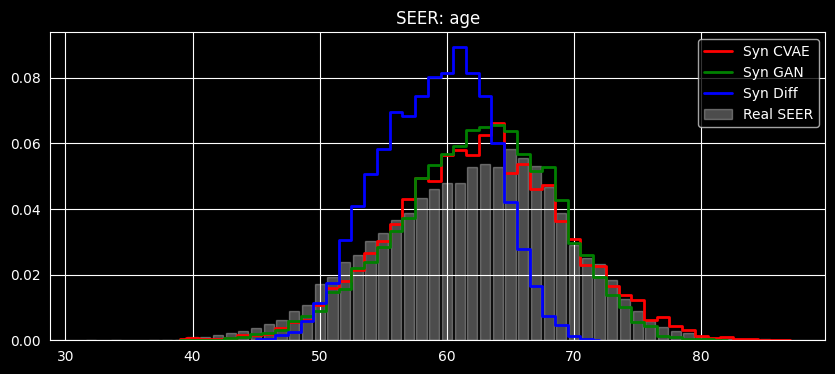

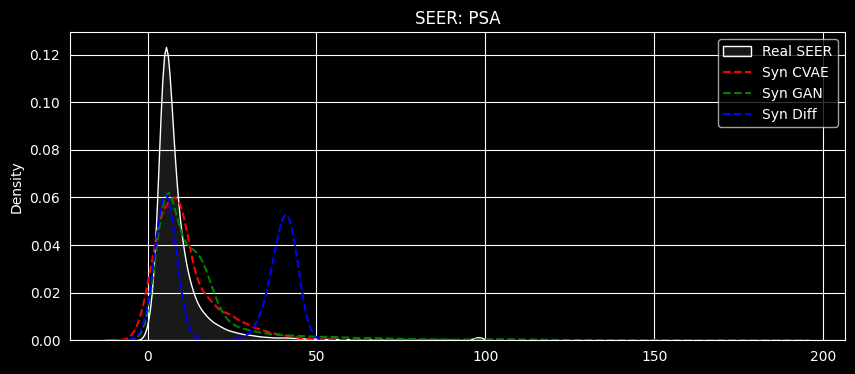

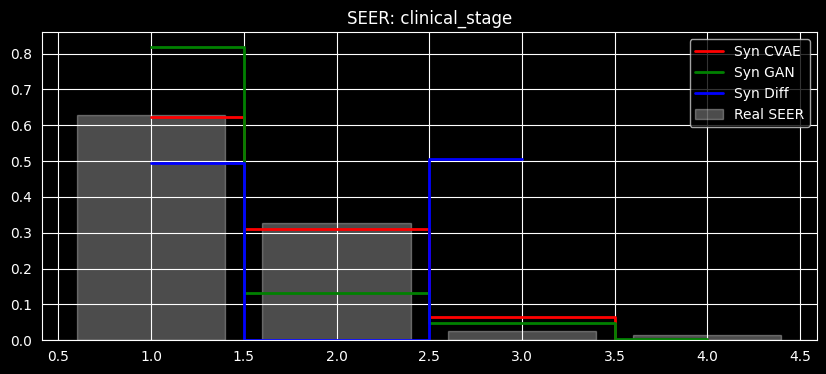

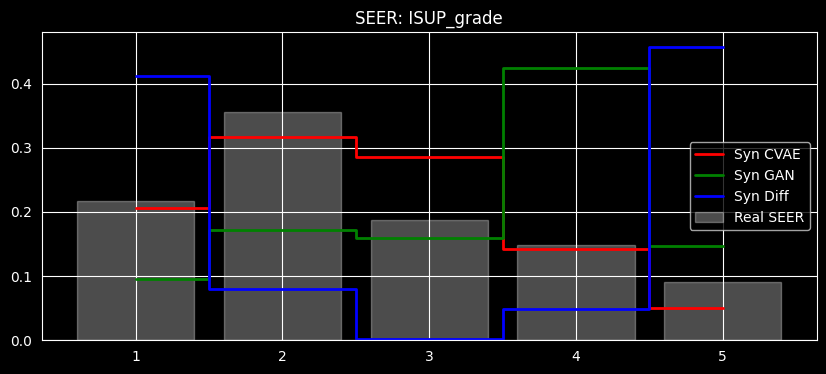

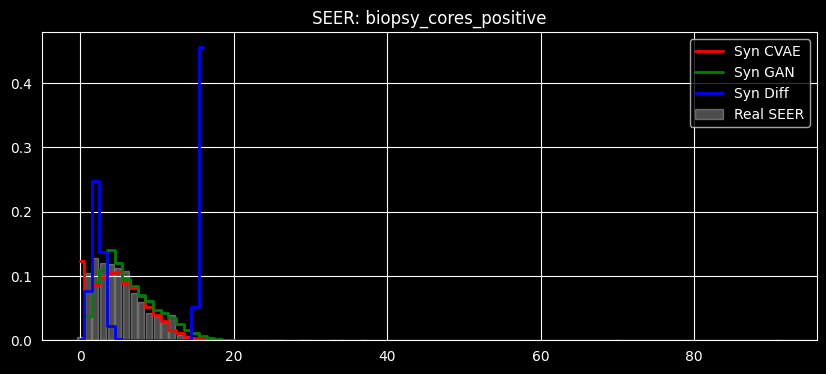

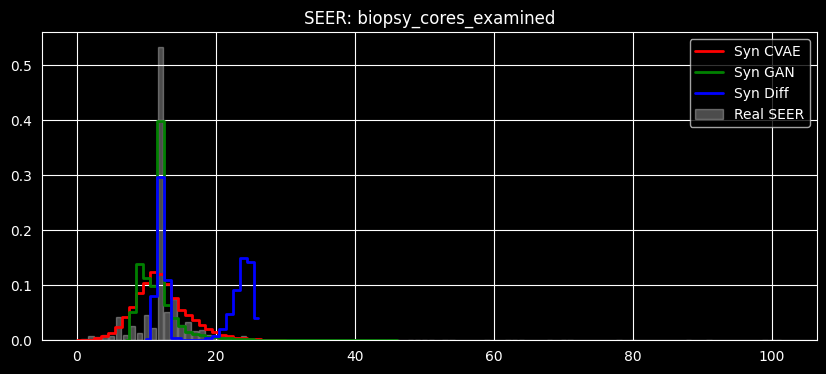

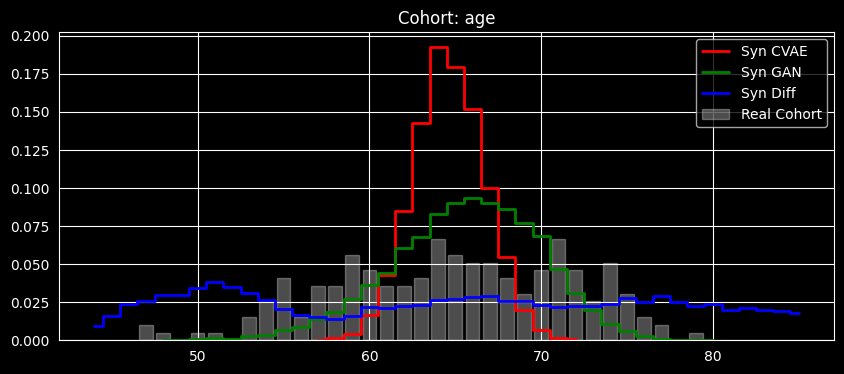

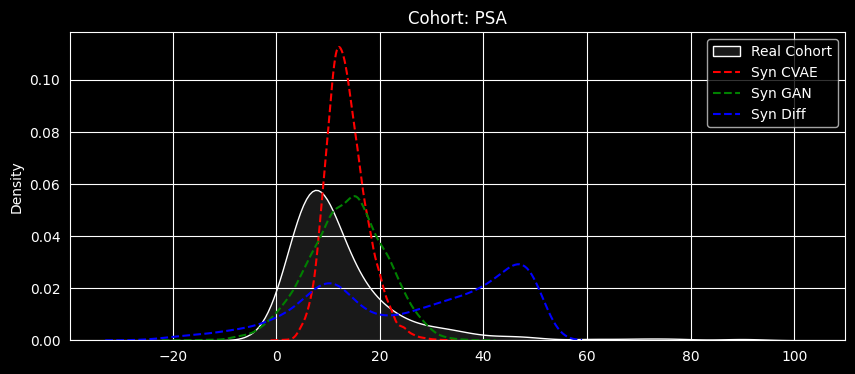

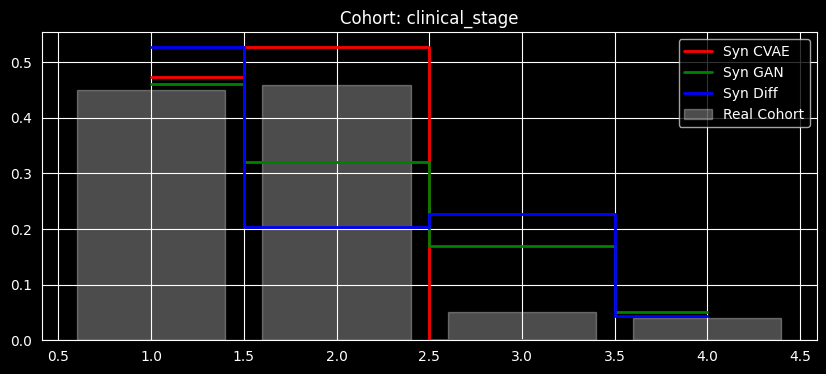

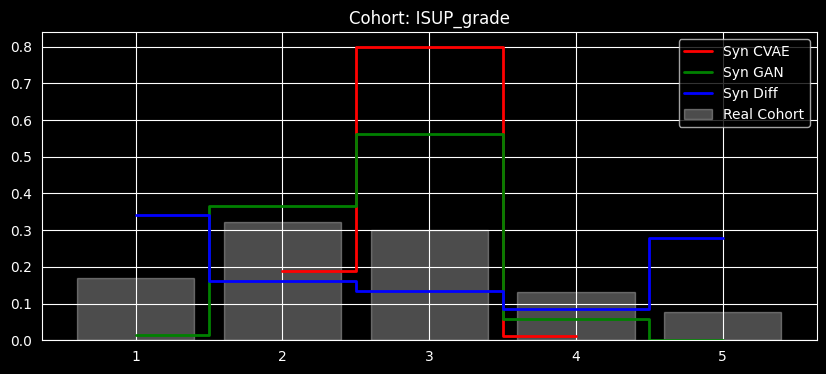

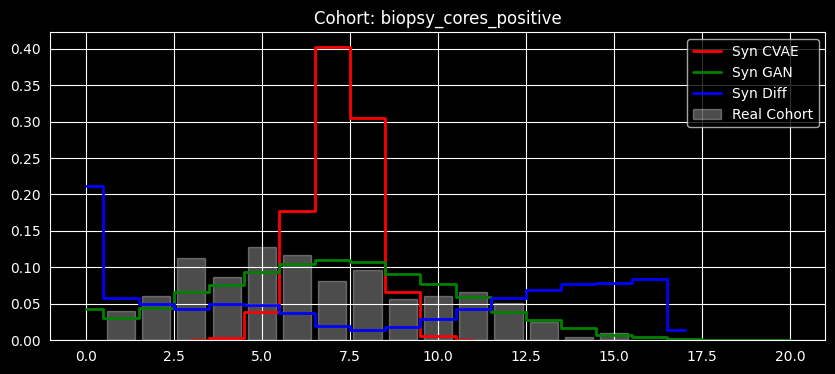

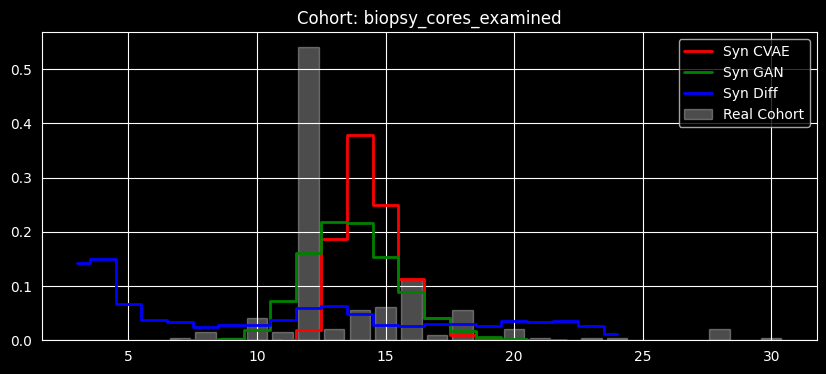

In [57]:
# Robust Visualization
for src_name in ["SEER", "Cohort"]:
    real_df = seer if src_name == "SEER" else cohort

    for col in feature_cols:
        plt.figure(figsize=(10, 4))

        # Real Data
        if col in discrete_cols:
            real_counts = real_df[col].value_counts(normalize=True).sort(col)
            plt.bar(real_counts[col], real_counts["proportion"], alpha=0.3, label=f"Real {src_name}", color='white')
        else:
            if real_df[col].std() > 1e-3:
                sns.kdeplot(real_df[col], fill=True, label=f"Real {src_name}", color='white', alpha=0.1)

        colors = ['red', 'green', 'blue']
        methods = ['CVAE', 'GAN', 'Diff']

        for i, method in enumerate(methods):
            key = f"{src_name}_{method}"
            X_syn, _ = synthetic_datasets[key]
            col_idx = feature_cols.index(col)
            data = X_syn[:, col_idx]

            if col in discrete_cols:
                unique, counts = np.unique(data, return_counts=True)
                props = counts / len(data)
                plt.step(unique, props, where='mid', label=f"Syn {method}", color=colors[i], linewidth=2)
            else:
                # Check variance to prevent empty plot warnings
                if np.std(data) > 1e-3:
                    sns.kdeplot(data, label=f"Syn {method}", color=colors[i], linestyle="--")

        plt.title(f"{src_name}: {col}")
        plt.legend()
        plt.show()

In [ ]:
print("=== Synthetic Training Experiment ===")
results_syn = []

for key, (X_syn, y_syn) in synthetic_datasets.items():
    # Determine Test Set (Train on Syn SEER -> Test Real Cohort)
    source = key.split("_")[0]
    if source == "SEER":
        X_test_std, y_test = X_cohort_std, y_cohort
        test_name = "Cohort"
    else:
        X_test_std, y_test = X_seer_std, y_seer
        test_name = "SEER"

    # Scale Synthetic Data
    scaler = StandardScaler().fit(X_syn)
    X_syn_std = scaler.transform(X_syn)

    print(f"Train on {key} -> Test on Real {test_name}")
    results_syn.append(train_eval_svm(X_syn_std, y_syn, X_test_std, y_test, f"SVM ({key})"))
    results_syn.append(train_eval_nn(X_syn_std, y_syn, X_test_std, y_test, f"NN ({key})"))

In [65]:
df_res = pl.DataFrame(results_syn)
df_res.write_csv(path.join(data_path, "synthetic_results.csv"))
display(df_res)

Model,AUC,Accuracy,Precision,Recall,F1
str,f64,f64,f64,f64,f64
"""SVM (SEER_CVAE)""",0.767611,0.668367,0.32967,0.882353,0.48
"""NN (SEER_CVAE)""",0.795207,0.739796,0.373134,0.735294,0.49505
"""SVM (SEER_GAN)""",0.711874,0.617347,0.292929,0.852941,0.43609
"""NN (SEER_GAN)""",0.704067,0.627551,0.285714,0.764706,0.416
"""SVM (SEER_Diff)""",0.723856,0.806122,0.4375,0.411765,0.424242
…,…,…,…,…,…
"""NN (Cohort_CVAE)""",0.782766,0.874491,0.260203,0.404227,0.316605
"""SVM (Cohort_GAN)""",0.673869,0.743807,0.130959,0.454586,0.203339
"""NN (Cohort_GAN)""",0.662051,0.872486,0.223722,0.31295,0.260918
